In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd
import tensorflow as tf

# Random and os for reproducibility
import random
import os

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression

# Processing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def score_model(model, x, y, n_splits=10, n_repeats=10):
    scoring = "neg_root_mean_squared_error"
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=SEED)
    scores = cross_val_score(model, x, y, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

<IPython.core.display.Javascript object>

In [4]:
def plot_predictions(linreg_model, df, index, x, y):
    d = df["Data/Hora"].values
    test_series = pd.DataFrame({"ccs28": y}, index=pd.to_datetime(d))
    pred_series = linreg_model.predict(scaler.transform(x))
    pred_series = pd.DataFrame({"ccs28-pred": pred_series}, index=pd.to_datetime(d))

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

    test_series.plot(ax=ax)
    ax.axvline(test_series.index[index], color="r")  # end of train dataset
    pred_series[index:].plot(ax=ax)
    ax.grid(which="both")
    ax.legend(
        ["train and test series", "end of train series", "predicted"], loc="upper left"
    )
    # ax.set_xlabel('Period', labelpad=20, fontsize=15)
    ax.set_ylabel("Compressive Strength - MPa", labelpad=20, fontsize=15)
    plt.show()

<IPython.core.display.Javascript object>

In [5]:
def plot_scores_box_plot(scores, repeats, n_splits):
    plt.figure(figsize=(15, 8))
    plt.boxplot(
        scores.reshape((repeats, n_splits)),
        labels=[str(r) for r in range(1, repeats + 1)],
        showmeans=True,
    )
    plt.ylabel("RMSE", labelpad=20, fontsize=15)
    plt.xlabel("Repeats", labelpad=20, fontsize=15)
    plt.show()

<IPython.core.display.Javascript object>

In [6]:
class BlockingTimeSeriesSplit:
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, X, y, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start:mid], indices[mid + margin : stop]


# Reference: https://goldinlocks.github.io/Time-Series-Cross-Validation/

<IPython.core.display.Javascript object>

In [7]:
def repeated_blocking_time_series(
    Estimator, Transform, x, y, train_period, test_period, repeats=10, params=None
):
    results = []
    max_samples = x.shape[0]

    for _ in range(repeats):
        i = 0
        scores = []
        for _ in range(0, max_samples // (train_period + test_period)):
            scaler = Transform()
            model = Estimator() if params is None else Estimator(**params)
            x_train = x[i : i + train_period]
            y_train = y[i : i + train_period]
            x_test = x[i + train_period : i + train_period + test_period]
            y_test = y[i + train_period : i + train_period + test_period]
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)

            model.fit(x_train, y_train)

            y_train_pred = model.predict(x_train)
            y_test_pred = model.predict(x_test)
            scores.append(
                score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
            )
            i += train_period + test_period

        scores_final = {key: [] for key, _ in scores[0].items()}
        for scores_dict in scores:
            for key, value in scores_dict.items():
                scores_final[key] += [value]
        results.append(scores_final)
    return results

<IPython.core.display.Javascript object>

In [8]:
def print_scores(scores, METRICS, METRICS_DICT):
    for phase in ["train", "test"]:
        print("******")
        print(f"[{phase.upper()}]")
        print("******")
        for metric in METRICS:
            name = METRICS_DICT[metric]
            print(
                f"{name}: %.3f (%.3f)"
                % (
                    np.abs(np.mean(scores[f"{phase}_" + metric])),
                    np.std(scores[f"{phase}_" + metric]),
                )
            )
        print("\n======================\n")

<IPython.core.display.Javascript object>

In [9]:
def score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred):
    TRAIN_RMSE = mean_squared_error(y_true=y_train, y_pred=y_train_pred, squared=False)
    TRAIN_MAE = mean_absolute_error(y_true=y_train, y_pred=y_train_pred)
    TRAIN_MAPE = mean_absolute_percentage_error(y_true=y_train, y_pred=y_train_pred)
    TRAIN_R2 = r2_score(y_true=y_train, y_pred=y_train_pred)

    TEST_RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    TEST_MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    TEST_MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    TEST_R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "train_neg_root_mean_squared_error": TRAIN_RMSE,
        "train_neg_mean_absolute_error": TRAIN_MAE,
        "train_neg_mean_absolute_percentage_error": TRAIN_MAPE,
        "train_r2": TRAIN_R2,
        "test_neg_root_mean_squared_error": TEST_RMSE,
        "test_neg_mean_absolute_error": TEST_MAE,
        "test_neg_mean_absolute_percentage_error": TEST_MAPE,
        "test_r2": TEST_R2,
    }
    return scores

<IPython.core.display.Javascript object>

In [10]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=256, activation="relu")),
    model.add(tf.keras.layers.Dense(units=128, activation="relu")),
    model.add(tf.keras.layers.Dense(units=64, activation="relu")),
    model.add(tf.keras.layers.Dense(units=32, activation="relu")),
    model.add(tf.keras.layers.Dense(units=16, activation="relu")),
    model.add(tf.keras.layers.Dropout(rate=0.10))
    model.add(tf.keras.layers.Dense(units=1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
    )
    return model

<IPython.core.display.Javascript object>

# Settings for Reproducibility

In [11]:
def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

<IPython.core.display.Javascript object>

In [12]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

# Baseline Model

# 1. Linear Regression

# Intercement

In [13]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered.

In [14]:
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28").values
x = df_no_cs.drop(["Data"], axis=1)

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Repeats:</b>10<br>
<b>Splits:</b>10<br>
    1. 10 folds of 123 samples each
    2. 90% train (1111 samples each fold)
    3. 10% test (123 samples each fold)
<b>Total:</b> 100 models<br>

In [15]:
set_seeds()
repeats = 10
n_splits = 10
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 3.769 (0.037)
MAE: 2.892 (0.021)
MAPE: 0.063 (0.001)
R2: 0.706 (0.006)


******
[TEST]
******
RMSE: 3.803 (0.326)
MAE: 2.904 (0.087)
MAPE: 0.063 (0.002)
R2: 0.697 (0.055)




<IPython.core.display.Javascript object>

# partner_iii

In [16]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [17]:
y = df_partner_iii.pop("28d compressive strength (MPa)").values
x = df_partner_iii.values

<IPython.core.display.Javascript object>

In [18]:
set_seeds()
repeats = 10
n_splits = 10
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 5.137 (0.055)
MAE: 3.990 (0.047)
MAPE: 0.079 (0.001)
R2: 0.463 (0.014)


******
[TEST]
******
RMSE: 5.165 (0.490)
MAE: 4.030 (0.426)
MAPE: 0.080 (0.009)
R2: 0.417 (0.145)




<IPython.core.display.Javascript object>

# partner_ii

In [19]:
df = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()

y = df_no_cs.pop("strength_28d").values
x = df_no_cs.drop(["sample_date"], axis=1)

<IPython.core.display.Javascript object>

In [20]:
set_seeds()
repeats = 10
n_splits = 10
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 2.195 (0.021)
MAE: 1.749 (0.016)
MAPE: 0.041 (0.000)
R2: 0.614 (0.007)


******
[TEST]
******
RMSE: 2.263 (0.207)
MAE: 1.787 (0.137)
MAPE: 0.042 (0.003)
R2: 0.580 (0.080)




<IPython.core.display.Javascript object>

# Transfer Learning - MLP

## Pre Trainning

In [21]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

# Intercement

In [22]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28").values
x = df_no_cs.drop(["Data"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [23]:
set_seeds()
model = get_model()
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

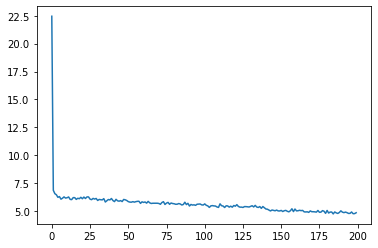

<IPython.core.display.Javascript object>

In [24]:
plt.plot(history.history["RMSE"])

In [25]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.686 (0.000)
MAE: 2.036 (0.000)
MAPE: 0.045 (0.000)
R2: 0.826 (0.000)


******
[TEST]
******
RMSE: 5.434 (0.000)
MAE: 4.642 (0.000)
MAPE: 0.086 (0.000)
R2: 0.128 (0.000)




<IPython.core.display.Javascript object>

In [26]:
model.evaluate(sc.transform(x_test), y_test)

35/35 [==============================] - 0s 713us/step - loss: 29.5294 - RMSE: 5.4341


[29.529441833496094, 5.4340996742248535]

<IPython.core.display.Javascript object>

In [27]:
trained_layers = history.model.layers

<IPython.core.display.Javascript object>

In [28]:
trained_layers

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [29]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [30]:
y = df_partner_iii.pop("28d compressive strength (MPa)").values
x = df_partner_iii.values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [31]:
set_seeds()
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Dense(units=256, activation="relu"))
trained_layers[1].trainable = True
model_2.add(trained_layers[1])
trained_layers[2].trainable = True
model_2.add(trained_layers[2])
trained_layers[3].trainable = True
model_2.add(trained_layers[3])
trained_layers[4].trainable = True
model_2.add(trained_layers[4])

model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=16, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=1))
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [32]:
sc = StandardScaler()
history = model_2.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=200,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

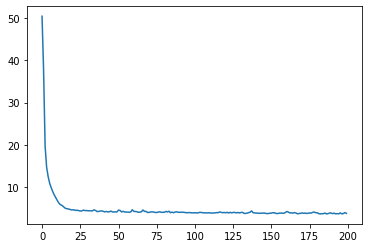

<IPython.core.display.Javascript object>

In [33]:
plt.plot(history.history["RMSE"])

In [34]:
y_train_pred = model_2.predict(sc.transform(x_train))
y_test_pred = model_2.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.746 (0.000)
MAE: 2.885 (0.000)
MAPE: 0.054 (0.000)
R2: 0.741 (0.000)


******
[TEST]
******
RMSE: 4.567 (0.000)
MAE: 3.241 (0.000)
MAPE: 0.065 (0.000)
R2: 0.287 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

In [35]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

# partner_i

In [36]:
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [37]:
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength").values
x = df_partner_i.drop(["Date"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [38]:
set_seeds()
model = get_model()
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

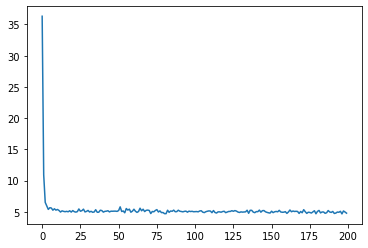

<IPython.core.display.Javascript object>

In [39]:
plt.plot(history.history["RMSE"])

In [40]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 1.514 (0.000)
MAE: 1.215 (0.000)
MAPE: 0.028 (0.000)
R2: 0.910 (0.000)


******
[TEST]
******
RMSE: 2.094 (0.000)
MAE: 1.707 (0.000)
MAPE: 0.039 (0.000)
R2: 0.823 (0.000)




<IPython.core.display.Javascript object>

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               9728      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                

<IPython.core.display.Javascript object>

In [42]:
trained_layers = history.model.layers

<IPython.core.display.Javascript object>

In [43]:
trained_layers

<IPython.core.display.Javascript object>

# partner_iii

In [44]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [45]:
y = df_partner_iii.pop("28d compressive strength (MPa)").values
x = df_partner_iii.values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [46]:
set_seeds()
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Dense(units=256, activation="relu"))
trained_layers[1].trainable = True
model_2.add(trained_layers[1])
trained_layers[2].trainable = True
model_2.add(trained_layers[2])
trained_layers[3].trainable = True
model_2.add(trained_layers[3])
trained_layers[4].trainable = True
model_2.add(trained_layers[4])

model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=16, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=32, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=1))
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [47]:
sc = StandardScaler()
history = model_2.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=500,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

In [48]:
y_train_pred = model_2.predict(sc.transform(x_train))
y_test_pred = model_2.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.128 (0.000)
MAE: 3.169 (0.000)
MAPE: 0.058 (0.000)
R2: 0.679 (0.000)


******
[TEST]
******
RMSE: 3.522 (0.000)
MAE: 2.653 (0.000)
MAPE: 0.051 (0.000)
R2: 0.151 (0.000)




<IPython.core.display.Javascript object>

In [49]:
trained_layers[0].get_config()

{'name': 'dense_11',
 'trainable': True,
 'dtype': 'float32',
 'units': 256,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

<IPython.core.display.Javascript object>

# Pre Trainning

In [50]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

# partner_i

In [51]:
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [52]:
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength").values
x = df_partner_i.drop(["Date"], axis=1).values

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [53]:
set_seeds()
model = get_model()
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

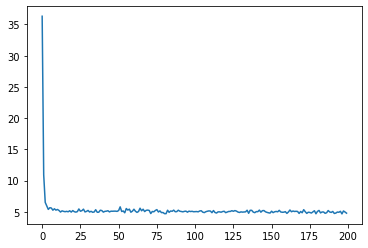

<IPython.core.display.Javascript object>

In [54]:
plt.plot(history.history["RMSE"])

In [55]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 1.514 (0.000)
MAE: 1.215 (0.000)
MAPE: 0.028 (0.000)
R2: 0.910 (0.000)


******
[TEST]
******
RMSE: 2.094 (0.000)
MAE: 1.707 (0.000)
MAPE: 0.039 (0.000)
R2: 0.823 (0.000)




<IPython.core.display.Javascript object>

In [56]:
trained_layers = history.model.layers

<IPython.core.display.Javascript object>

In [57]:
trained_layers

<IPython.core.display.Javascript object>

# Fine Tuning

# Intercement

In [58]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28").values
x = df_no_cs.drop(["Data"], axis=1).values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [59]:
set_seeds()
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Dense(units=256, activation="relu"))
trained_layers[1].trainable = True
model_2.add(trained_layers[1])
trained_layers[2].trainable = True
model_2.add(trained_layers[2])
trained_layers[3].trainable = True
model_2.add(trained_layers[3])
trained_layers[4].trainable = True
model_2.add(trained_layers[4])

model_2.add(tf.keras.layers.Dense(units=256, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=256, activation="relu"))
model_2.add(tf.keras.layers.Dense(units=1))
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [60]:
sc = StandardScaler()
history = model_2.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

In [61]:
y_test_pred.shape

(247, 1)

<IPython.core.display.Javascript object>

In [62]:
y_train_pred = model_2.predict(sc.transform(x_train))
y_test_pred = model_2.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.446 (0.000)
MAE: 1.829 (0.000)
MAPE: 0.041 (0.000)
R2: 0.855 (0.000)


******
[TEST]
******
RMSE: 4.394 (0.000)
MAE: 3.636 (0.000)
MAPE: 0.067 (0.000)
R2: 0.430 (0.000)




<IPython.core.display.Javascript object>

# Experiments with same variables

In [63]:
def get_model(shape, include_top=True):
    inputs = tf.keras.Input(shape=shape)
    x = tf.keras.layers.Dense(units=256, activation="relu")(inputs)
    x = tf.keras.layers.Dense(units=128, activation="relu")(x)
    x = tf.keras.layers.Dense(units=64, activation="relu")(x)
    x = tf.keras.layers.Dense(units=32, activation="relu")(x)
    x = tf.keras.layers.Dense(units=16, activation="relu")(x)
    if include_top:
        x = tf.keras.layers.Dropout(0.1)(x)
        outputs = tf.keras.layers.Dense(units=1)(x)
        model = tf.keras.Model(inputs, outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
    else:
        model = tf.keras.Model(inputs, x)
    return model

<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i

In [64]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

In [65]:
COMMON_FEATURES = ["mgo", "al2o3", "sio2", "so3", "k2o", "fe2o3"]

<IPython.core.display.Javascript object>

In [66]:
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [67]:
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
x = df_partner_i.drop(["Date"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [68]:
set_seeds()

model = get_model(shape=(x_train.shape[-1]))
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

In [69]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [70]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [71]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [72]:
set_seeds()

model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [73]:
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

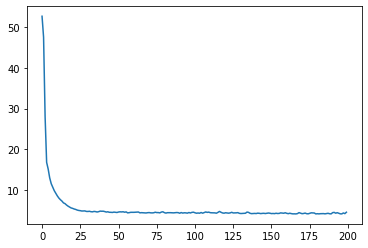

<IPython.core.display.Javascript object>

In [74]:
plt.plot(history.history["RMSE"])

In [75]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.778 (0.000)
MAE: 3.826 (0.000)
MAPE: 0.072 (0.000)
R2: 0.569 (0.000)


******
[TEST]
******
RMSE: 3.459 (0.000)
MAE: 2.663 (0.000)
MAPE: 0.051 (0.000)
R2: 0.181 (0.000)




<IPython.core.display.Javascript object>

# Intercement

In [76]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [77]:
set_seeds()

model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = False

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
class1 = tf.keras.layers.Dense(128, activation="relu")(class1)
class1 = tf.keras.layers.Dense(64, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [78]:
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

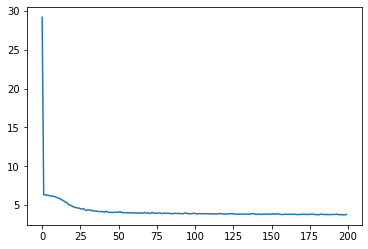

<IPython.core.display.Javascript object>

In [79]:
plt.plot(history.history["RMSE"])

In [80]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.774 (0.000)
MAE: 2.856 (0.000)
MAPE: 0.065 (0.000)
R2: 0.656 (0.000)


******
[TEST]
******
RMSE: 6.330 (0.000)
MAE: 5.376 (0.000)
MAPE: 0.098 (0.000)
R2: 0.183 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

In [81]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

# partner_i + partner_ii

In [82]:
batch_size = 32
epochs = 200
verbose = 1

<IPython.core.display.Javascript object>

In [83]:
COMMON_FEATURES = ["mgo", "al2o3", "sio2", "so3", "k2o", "fe2o3"]

<IPython.core.display.Javascript object>

In [84]:
df_partner_ii = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y_1 = df_no_cs.pop("strength_28d")
x_1 = df_no_cs.rename({"sample_date": "date"}, axis=1)

df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y_2 = df_partner_i.pop("28 day Compressive strength")
x_2 = df_partner_i

x_2.columns = x_2.columns.str.lower()
x_2 = x_2.drop(set(x_2.columns) - set(x_1.columns), axis=1)
x_1 = x_1[x_2.columns]


y_1.name = "cs28"
y_2.name = "cs28"

x = pd.concat([x_1, x_2], axis=0).reset_index(drop=True)
y = pd.concat([y_1, y_2], axis=0).reset_index(drop=True)

x = pd.concat([x, y], axis=1)
x["date"] = x["date"].apply(lambda x: x[:10])
x["date"] = pd.to_datetime(x["date"])
x = x.sort_values(by="date").reset_index(drop=True)
y = x.pop("cs28")
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [85]:
set_seeds()
model = get_model(shape=(x_train.shape[-1]))
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

Epoch 1/200
58/58 [==============================] - 0s 2ms/step - loss: 1194.8732 - RMSE: 34.5669
Epoch 2/200
58/58 [==============================] - 0s 2ms/step - loss: 59.3829 - RMSE: 7.7060
Epoch 3/200
58/58 [==============================] - 0s 2ms/step - loss: 49.4910 - RMSE: 7.0350
Epoch 4/200
58/58 [==============================] - 0s 2ms/step - loss: 48.6884 - RMSE: 6.9777
Epoch 5/200
58/58 [==============================] - 0s 1ms/step - loss: 45.8872 - RMSE: 6.7740
Epoch 6/200
58/58 [==============================] - 0s 2ms/step - loss: 40.5723 - RMSE: 6.3696
Epoch 7/200
58/58 [==============================] - 0s 2ms/step - loss: 41.1309 - RMSE: 6.4133
Epoch 8/200
58/58 [==============================] - 0s 1ms/step - loss: 41.2647 - RMSE: 6.4238
Epoch 9/200
58/58 [==============================] - 0s 1ms/step - loss: 38.2444 - RMSE: 6.1842
Epoch 10/200
58/58 [==============================] - 0s 1ms/step - loss: 38.5093 - RMSE: 6.2056
Epoch 11/200
58/58 [================

58/58 [==============================] - 0s 2ms/step - loss: 31.6628 - RMSE: 5.6270
Epoch 86/200
58/58 [==============================] - 0s 1ms/step - loss: 32.0591 - RMSE: 5.6621
Epoch 87/200
58/58 [==============================] - 0s 1ms/step - loss: 29.8271 - RMSE: 5.4614
Epoch 88/200
58/58 [==============================] - 0s 2ms/step - loss: 30.6640 - RMSE: 5.5375
Epoch 89/200
58/58 [==============================] - 0s 2ms/step - loss: 32.4809 - RMSE: 5.6992
Epoch 90/200
58/58 [==============================] - 0s 2ms/step - loss: 32.3300 - RMSE: 5.6859
Epoch 91/200
58/58 [==============================] - 0s 2ms/step - loss: 29.6650 - RMSE: 5.4466
Epoch 92/200
58/58 [==============================] - 0s 2ms/step - loss: 32.5722 - RMSE: 5.7072
Epoch 93/200
58/58 [==============================] - 0s 2ms/step - loss: 31.9701 - RMSE: 5.6542
Epoch 94/200
58/58 [==============================] - 0s 2ms/step - loss: 31.5862 - RMSE: 5.6202
Epoch 95/200
58/58 [=======================

58/58 [==============================] - 0s 2ms/step - loss: 28.8747 - RMSE: 5.3735
Epoch 169/200
58/58 [==============================] - 0s 2ms/step - loss: 30.0568 - RMSE: 5.4824
Epoch 170/200
58/58 [==============================] - 0s 2ms/step - loss: 27.9767 - RMSE: 5.2893
Epoch 171/200
58/58 [==============================] - 0s 1ms/step - loss: 29.9739 - RMSE: 5.4748
Epoch 172/200
58/58 [==============================] - 0s 1ms/step - loss: 28.3960 - RMSE: 5.3288
Epoch 173/200
58/58 [==============================] - 0s 1ms/step - loss: 29.6619 - RMSE: 5.4463
Epoch 174/200
58/58 [==============================] - 0s 2ms/step - loss: 29.4481 - RMSE: 5.4266
Epoch 175/200
58/58 [==============================] - 0s 1ms/step - loss: 30.7651 - RMSE: 5.5466
Epoch 176/200
58/58 [==============================] - 0s 2ms/step - loss: 29.3800 - RMSE: 5.4203
Epoch 177/200
58/58 [==============================] - 0s 2ms/step - loss: 29.0353 - RMSE: 5.3884
Epoch 178/200
58/58 [=============

<IPython.core.display.Javascript object>

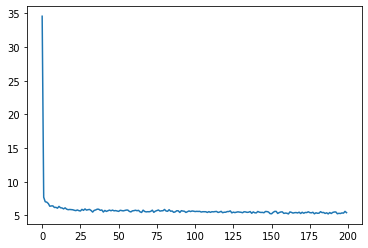

<IPython.core.display.Javascript object>

In [86]:
plt.plot(history.history["RMSE"])

In [87]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.300 (0.000)
MAE: 2.687 (0.000)
MAPE: 0.061 (0.000)
R2: 0.405 (0.000)


******
[TEST]
******
RMSE: 3.664 (0.000)
MAE: 3.152 (0.000)
MAPE: 0.075 (0.000)
R2: 0.418 (0.000)




<IPython.core.display.Javascript object>

In [88]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [89]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [90]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [91]:
set_seeds()

model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [92]:
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

Epoch 1/200
14/14 [==============================] - 0s 2ms/step - loss: 2780.1824 - RMSE: 52.7274
Epoch 2/200
14/14 [==============================] - 0s 2ms/step - loss: 2264.4934 - RMSE: 47.5867
Epoch 3/200
14/14 [==============================] - 0s 2ms/step - loss: 785.9670 - RMSE: 28.0351
Epoch 4/200
14/14 [==============================] - 0s 2ms/step - loss: 281.7068 - RMSE: 16.7841
Epoch 5/200
14/14 [==============================] - 0s 2ms/step - loss: 229.6888 - RMSE: 15.1555
Epoch 6/200
14/14 [==============================] - 0s 2ms/step - loss: 168.3749 - RMSE: 12.9759
Epoch 7/200
14/14 [==============================] - 0s 2ms/step - loss: 133.1390 - RMSE: 11.5386
Epoch 8/200
14/14 [==============================] - 0s 2ms/step - loss: 113.2314 - RMSE: 10.6410
Epoch 9/200
14/14 [==============================] - 0s 2ms/step - loss: 96.2452 - RMSE: 9.8105
Epoch 10/200
14/14 [==============================] - 0s 2ms/step - loss: 83.7903 - RMSE: 9.1537
Epoch 11/200
14/14 [=

14/14 [==============================] - 0s 2ms/step - loss: 19.3701 - RMSE: 4.4011
Epoch 86/200
14/14 [==============================] - 0s 2ms/step - loss: 19.1525 - RMSE: 4.3764
Epoch 87/200
14/14 [==============================] - 0s 2ms/step - loss: 18.9944 - RMSE: 4.3583
Epoch 88/200
14/14 [==============================] - 0s 2ms/step - loss: 19.4135 - RMSE: 4.4061
Epoch 89/200
14/14 [==============================] - 0s 2ms/step - loss: 19.6833 - RMSE: 4.4366
Epoch 90/200
14/14 [==============================] - 0s 2ms/step - loss: 19.4652 - RMSE: 4.4119
Epoch 91/200
14/14 [==============================] - 0s 2ms/step - loss: 18.2263 - RMSE: 4.2692
Epoch 92/200
14/14 [==============================] - 0s 2ms/step - loss: 19.6537 - RMSE: 4.4333
Epoch 93/200
14/14 [==============================] - 0s 2ms/step - loss: 18.5290 - RMSE: 4.3045
Epoch 94/200
14/14 [==============================] - 0s 2ms/step - loss: 19.1924 - RMSE: 4.3809
Epoch 95/200
14/14 [=======================

14/14 [==============================] - 0s 2ms/step - loss: 17.4450 - RMSE: 4.1767
Epoch 169/200
14/14 [==============================] - 0s 2ms/step - loss: 19.4859 - RMSE: 4.4143
Epoch 170/200
14/14 [==============================] - 0s 2ms/step - loss: 18.2793 - RMSE: 4.2754
Epoch 171/200
14/14 [==============================] - 0s 2ms/step - loss: 17.3014 - RMSE: 4.1595
Epoch 172/200
14/14 [==============================] - 0s 2ms/step - loss: 17.6924 - RMSE: 4.2062
Epoch 173/200
14/14 [==============================] - 0s 2ms/step - loss: 18.5178 - RMSE: 4.3032
Epoch 174/200
14/14 [==============================] - 0s 2ms/step - loss: 17.2816 - RMSE: 4.1571
Epoch 175/200
14/14 [==============================] - 0s 2ms/step - loss: 17.0076 - RMSE: 4.1240
Epoch 176/200
14/14 [==============================] - 0s 2ms/step - loss: 17.9831 - RMSE: 4.2406
Epoch 177/200
14/14 [==============================] - 0s 2ms/step - loss: 19.0949 - RMSE: 4.3698
Epoch 178/200
14/14 [=============

<IPython.core.display.Javascript object>

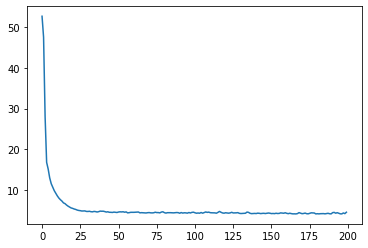

<IPython.core.display.Javascript object>

In [93]:
plt.plot(history.history["RMSE"])

In [94]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.778 (0.000)
MAE: 3.826 (0.000)
MAPE: 0.072 (0.000)
R2: 0.569 (0.000)


******
[TEST]
******
RMSE: 3.459 (0.000)
MAE: 2.663 (0.000)
MAPE: 0.051 (0.000)
R2: 0.181 (0.000)




<IPython.core.display.Javascript object>

# Intercement

In [95]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()

y = df_no_cs.pop("RC28")
x = df_no_cs.drop(["Data"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [96]:
set_seeds()

model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = False

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
class1 = tf.keras.layers.Dense(128, activation="relu")(class1)
class1 = tf.keras.layers.Dense(64, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [97]:
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

Epoch 1/200
139/139 [==============================] - 1s 1ms/step - loss: 851.5047 - RMSE: 29.1806
Epoch 2/200
139/139 [==============================] - 0s 2ms/step - loss: 40.2966 - RMSE: 6.3480
Epoch 3/200
139/139 [==============================] - 0s 1ms/step - loss: 39.9110 - RMSE: 6.3175
Epoch 4/200
139/139 [==============================] - 0s 1ms/step - loss: 39.4256 - RMSE: 6.2790
Epoch 5/200
139/139 [==============================] - 0s 1ms/step - loss: 38.9707 - RMSE: 6.2426
Epoch 6/200
139/139 [==============================] - 0s 1ms/step - loss: 38.4692 - RMSE: 6.2024
Epoch 7/200
139/139 [==============================] - 0s 2ms/step - loss: 37.9620 - RMSE: 6.1613
Epoch 8/200
139/139 [==============================] - 0s 1ms/step - loss: 37.5049 - RMSE: 6.1241
Epoch 9/200
139/139 [==============================] - 0s 1ms/step - loss: 37.1906 - RMSE: 6.0984
Epoch 10/200
139/139 [==============================] - 0s 1ms/step - loss: 36.2997 - RMSE: 6.0249
Epoch 11/200
139/

139/139 [==============================] - 0s 2ms/step - loss: 15.6724 - RMSE: 3.9588
Epoch 84/200
139/139 [==============================] - 0s 2ms/step - loss: 15.5129 - RMSE: 3.9386
Epoch 85/200
139/139 [==============================] - 0s 2ms/step - loss: 15.1571 - RMSE: 3.8932
Epoch 86/200
139/139 [==============================] - 0s 1ms/step - loss: 15.1577 - RMSE: 3.8933
Epoch 87/200
139/139 [==============================] - 0s 1ms/step - loss: 15.3371 - RMSE: 3.9163
Epoch 88/200
139/139 [==============================] - 0s 2ms/step - loss: 15.5365 - RMSE: 3.9416
Epoch 89/200
139/139 [==============================] - 0s 2ms/step - loss: 15.2227 - RMSE: 3.9016
Epoch 90/200
139/139 [==============================] - 0s 1ms/step - loss: 15.4714 - RMSE: 3.9334
Epoch 91/200
139/139 [==============================] - 0s 1ms/step - loss: 15.1687 - RMSE: 3.8947
Epoch 92/200
139/139 [==============================] - 0s 1ms/step - loss: 15.0684 - RMSE: 3.8818
Epoch 93/200
139/139 [=

139/139 [==============================] - 0s 1ms/step - loss: 14.4834 - RMSE: 3.8057
Epoch 166/200
139/139 [==============================] - 0s 1ms/step - loss: 14.6173 - RMSE: 3.8233
Epoch 167/200
139/139 [==============================] - 0s 1ms/step - loss: 14.4145 - RMSE: 3.7966
Epoch 168/200
139/139 [==============================] - 0s 1ms/step - loss: 14.2135 - RMSE: 3.7701
Epoch 169/200
139/139 [==============================] - 0s 1ms/step - loss: 14.3453 - RMSE: 3.7875
Epoch 170/200
139/139 [==============================] - 0s 1ms/step - loss: 14.3364 - RMSE: 3.7863
Epoch 171/200
139/139 [==============================] - 0s 1ms/step - loss: 14.5736 - RMSE: 3.8175
Epoch 172/200
139/139 [==============================] - 0s 1ms/step - loss: 14.5911 - RMSE: 3.8198
Epoch 173/200
139/139 [==============================] - 0s 1ms/step - loss: 14.2984 - RMSE: 3.7813
Epoch 174/200
139/139 [==============================] - 0s 1ms/step - loss: 14.4672 - RMSE: 3.8036
Epoch 175/200


<IPython.core.display.Javascript object>

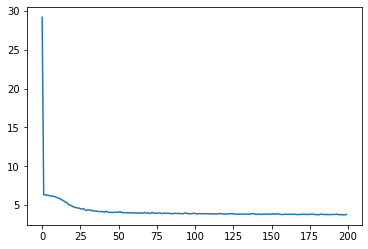

<IPython.core.display.Javascript object>

In [98]:
plt.plot(history.history["RMSE"])

In [99]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.774 (0.000)
MAE: 2.856 (0.000)
MAPE: 0.065 (0.000)
R2: 0.656 (0.000)


******
[TEST]
******
RMSE: 6.330 (0.000)
MAE: 5.376 (0.000)
MAPE: 0.098 (0.000)
R2: 0.183 (0.000)




<IPython.core.display.Javascript object>

# Experiments with Same Variables

In [100]:
df_intercement = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_partner_ii = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [101]:
set(df_intercement.columns.str.lower()).intersection(
    set(df_partner_ii.columns.str.lower())
)

{'al2o3', 'fe2o3', 'k2o', 'mgo', 'sio2', 'so3'}

<IPython.core.display.Javascript object>

In [102]:
set(df_intercement.columns.str.lower()).intersection(
    set(df_partner_i.columns.str.lower())
)

{'al2o3', 'fe2o3', 'k2o', 'mgo', 'sio2', 'so3'}

<IPython.core.display.Javascript object>

In [103]:
set(df_partner_ii.columns.str.lower()).intersection(
    set(df_partner_i.columns.str.lower())
)

{'al2o3',
 'aluminate',
 'cao',
 'fe2o3',
 'ferrite',
 'k2o',
 'mgo',
 'na2o',
 'sio2',
 'so3'}

<IPython.core.display.Javascript object>

# Baseline Model

# Linear Regression

In [104]:
COMMON_FEATURES = [
    "cao",
    "sio2",
    "al2o3",
    "fe2o3",
    "aluminate",
    "na2o",
    "mgo",
    "so3",
    "ferrite",
    "k2o",
]

<IPython.core.display.Javascript object>

# partner_ii

In [105]:
df_partner_ii = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y = df_no_cs.pop("strength_28d")
x = df_no_cs.rename({"sample_date": "date"}, axis=1)

x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

<IPython.core.display.Javascript object>

In [106]:
repeats = 10
n_splits = 10
set_seeds()
pipeline = Pipeline(
    [("transformer", StandardScaler()), ("estimator", LinearRegression())]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
)
# scores = np.abs(scores)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

Repeated Cross Validation:
Repeats: 10
n_splits: 10

******
[TRAIN]
******
RMSE: 2.708 (0.023)
MAE: 2.159 (0.018)
MAPE: 0.050 (0.000)
R2: 0.413 (0.009)


******
[TEST]
******
RMSE: 2.764 (0.231)
MAE: 2.190 (0.156)
MAPE: 0.051 (0.004)
R2: 0.375 (0.104)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i

In [107]:
batch_size = 32
epochs = 200
verbose = 1

<IPython.core.display.Javascript object>

In [108]:
COMMON_FEATURES = [
    "cao",
    "sio2",
    "al2o3",
    "fe2o3",
    "aluminate",
    "na2o",
    "mgo",
    "so3",
    "ferrite",
    "k2o",
]

<IPython.core.display.Javascript object>

In [109]:
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)

<IPython.core.display.Javascript object>

In [110]:
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
x = df_partner_i.drop(["Date"], axis=1)
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [111]:
set_seeds()
model = get_model(shape=(x_train.shape[-1]))
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

Epoch 1/200
31/31 [==============================] - 0s 1ms/step - loss: 1737.5958 - RMSE: 41.6845
Epoch 2/200
31/31 [==============================] - 0s 1ms/step - loss: 383.6374 - RMSE: 19.5867
Epoch 3/200
31/31 [==============================] - 0s 1ms/step - loss: 89.5576 - RMSE: 9.4635
Epoch 4/200
31/31 [==============================] - 0s 2ms/step - loss: 72.1684 - RMSE: 8.4952
Epoch 5/200
31/31 [==============================] - 0s 2ms/step - loss: 60.3155 - RMSE: 7.7663
Epoch 6/200
31/31 [==============================] - 0s 1ms/step - loss: 59.7847 - RMSE: 7.7321
Epoch 7/200
31/31 [==============================] - 0s 1ms/step - loss: 56.0485 - RMSE: 7.4866
Epoch 8/200
31/31 [==============================] - 0s 1ms/step - loss: 50.4306 - RMSE: 7.1015
Epoch 9/200
31/31 [==============================] - 0s 2ms/step - loss: 51.6459 - RMSE: 7.1865
Epoch 10/200
31/31 [==============================] - 0s 2ms/step - loss: 43.8159 - RMSE: 6.6194
Epoch 11/200
31/31 [==============

31/31 [==============================] - 0s 2ms/step - loss: 34.2999 - RMSE: 5.8566
Epoch 86/200
31/31 [==============================] - 0s 1ms/step - loss: 33.6184 - RMSE: 5.7981
Epoch 87/200
31/31 [==============================] - 0s 2ms/step - loss: 35.4885 - RMSE: 5.9572
Epoch 88/200
31/31 [==============================] - 0s 2ms/step - loss: 33.2968 - RMSE: 5.7703
Epoch 89/200
31/31 [==============================] - 0s 2ms/step - loss: 34.8814 - RMSE: 5.9060
Epoch 90/200
31/31 [==============================] - 0s 2ms/step - loss: 36.8509 - RMSE: 6.0705
Epoch 91/200
31/31 [==============================] - 0s 1ms/step - loss: 37.8647 - RMSE: 6.1534
Epoch 92/200
31/31 [==============================] - 0s 2ms/step - loss: 34.6462 - RMSE: 5.8861
Epoch 93/200
31/31 [==============================] - 0s 2ms/step - loss: 36.2723 - RMSE: 6.0226
Epoch 94/200
31/31 [==============================] - 0s 2ms/step - loss: 34.8664 - RMSE: 5.9048
Epoch 95/200
31/31 [=======================

31/31 [==============================] - 0s 2ms/step - loss: 32.8953 - RMSE: 5.7354
Epoch 169/200
31/31 [==============================] - 0s 2ms/step - loss: 34.1596 - RMSE: 5.8446
Epoch 170/200
31/31 [==============================] - 0s 2ms/step - loss: 32.4082 - RMSE: 5.6928
Epoch 171/200
31/31 [==============================] - 0s 2ms/step - loss: 33.3973 - RMSE: 5.7790
Epoch 172/200
31/31 [==============================] - 0s 2ms/step - loss: 37.2954 - RMSE: 6.1070
Epoch 173/200
31/31 [==============================] - 0s 2ms/step - loss: 34.0499 - RMSE: 5.8352
Epoch 174/200
31/31 [==============================] - 0s 2ms/step - loss: 32.9946 - RMSE: 5.7441
Epoch 175/200
31/31 [==============================] - 0s 1ms/step - loss: 32.4920 - RMSE: 5.7002
Epoch 176/200
31/31 [==============================] - 0s 2ms/step - loss: 31.9044 - RMSE: 5.6484
Epoch 177/200
31/31 [==============================] - 0s 2ms/step - loss: 32.5216 - RMSE: 5.7028
Epoch 178/200
31/31 [=============

<IPython.core.display.Javascript object>

In [112]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.307 (0.000)
MAE: 2.636 (0.000)
MAPE: 0.061 (0.000)
R2: 0.571 (0.000)


******
[TEST]
******
RMSE: 3.987 (0.000)
MAE: 3.326 (0.000)
MAPE: 0.075 (0.000)
R2: 0.356 (0.000)




<IPython.core.display.Javascript object>

In [113]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_ii

In [114]:
df_partner_ii = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y = df_no_cs.pop("strength_28d")
x = df_no_cs.rename({"sample_date": "date"}, axis=1)

x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [115]:
set_seeds()
model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
class1 = tf.keras.layers.Dense(128, activation="relu")(class1)
class1 = tf.keras.layers.Dense(64, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [116]:
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)


Epoch 1/200
27/27 [==============================] - 0s 2ms/step - loss: 1659.0985 - RMSE: 40.7320
Epoch 2/200
27/27 [==============================] - 0s 2ms/step - loss: 106.4373 - RMSE: 10.3168
Epoch 3/200
27/27 [==============================] - 0s 2ms/step - loss: 20.5840 - RMSE: 4.5370
Epoch 4/200
27/27 [==============================] - 0s 2ms/step - loss: 9.9066 - RMSE: 3.1475
Epoch 5/200
27/27 [==============================] - 0s 2ms/step - loss: 10.0421 - RMSE: 3.1689
Epoch 6/200
27/27 [==============================] - 0s 2ms/step - loss: 10.0574 - RMSE: 3.1713
Epoch 7/200
27/27 [==============================] - 0s 2ms/step - loss: 9.7986 - RMSE: 3.1303
Epoch 8/200
27/27 [==============================] - 0s 2ms/step - loss: 9.7069 - RMSE: 3.1156
Epoch 9/200
27/27 [==============================] - 0s 3ms/step - loss: 9.5968 - RMSE: 3.0979
Epoch 10/200
27/27 [==============================] - 0s 2ms/step - loss: 9.9455 - RMSE: 3.1536
Epoch 11/200
27/27 [===================

27/27 [==============================] - 0s 2ms/step - loss: 7.5603 - RMSE: 2.7496
Epoch 87/200
27/27 [==============================] - 0s 2ms/step - loss: 6.8130 - RMSE: 2.6102
Epoch 88/200
27/27 [==============================] - 0s 2ms/step - loss: 6.9884 - RMSE: 2.6436
Epoch 89/200
27/27 [==============================] - 0s 2ms/step - loss: 6.8334 - RMSE: 2.6141
Epoch 90/200
27/27 [==============================] - 0s 2ms/step - loss: 7.0549 - RMSE: 2.6561
Epoch 91/200
27/27 [==============================] - 0s 2ms/step - loss: 6.8225 - RMSE: 2.6120
Epoch 92/200
27/27 [==============================] - 0s 2ms/step - loss: 7.1561 - RMSE: 2.6751
Epoch 93/200
27/27 [==============================] - 0s 2ms/step - loss: 7.5567 - RMSE: 2.7489
Epoch 94/200
27/27 [==============================] - 0s 2ms/step - loss: 8.1171 - RMSE: 2.8490
Epoch 95/200
27/27 [==============================] - 0s 2ms/step - loss: 7.3943 - RMSE: 2.7192
Epoch 96/200
27/27 [==============================] -

27/27 [==============================] - 0s 2ms/step - loss: 6.9466 - RMSE: 2.6356
Epoch 171/200
27/27 [==============================] - 0s 2ms/step - loss: 7.6815 - RMSE: 2.7716
Epoch 172/200
27/27 [==============================] - 0s 2ms/step - loss: 8.9740 - RMSE: 2.9957
Epoch 173/200
27/27 [==============================] - 0s 2ms/step - loss: 6.7934 - RMSE: 2.6064
Epoch 174/200
27/27 [==============================] - 0s 2ms/step - loss: 7.0086 - RMSE: 2.6474
Epoch 175/200
27/27 [==============================] - 0s 2ms/step - loss: 6.6893 - RMSE: 2.5864
Epoch 176/200
27/27 [==============================] - 0s 2ms/step - loss: 6.2917 - RMSE: 2.5083
Epoch 177/200
27/27 [==============================] - 0s 2ms/step - loss: 6.4029 - RMSE: 2.5304
Epoch 178/200
27/27 [==============================] - 0s 2ms/step - loss: 6.5167 - RMSE: 2.5528
Epoch 179/200
27/27 [==============================] - 0s 2ms/step - loss: 6.5415 - RMSE: 2.5576
Epoch 180/200
27/27 [=======================

<IPython.core.display.Javascript object>

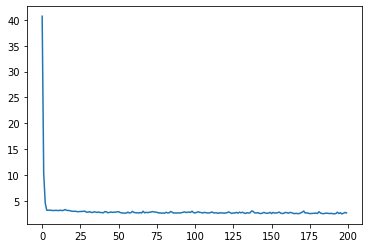

<IPython.core.display.Javascript object>

In [117]:
plt.plot(history.history["RMSE"])

In [118]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.007 (0.000)
MAE: 2.423 (0.000)
MAPE: 0.054 (0.000)
R2: 0.150 (0.000)


******
[TEST]
******
RMSE: 2.919 (0.000)
MAE: 2.358 (0.000)
MAPE: 0.061 (0.000)
R2: 0.099 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i + Intercement

In [119]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

In [120]:
COMMON_FEATURES = ["mgo", "al2o3", "sio2", "so3", "k2o", "fe2o3"]

<IPython.core.display.Javascript object>

In [121]:
df = pd.read_csv("../../../data/processed/Intercement/cement-shipping.csv")
df_no_cs = df.drop(
    [
        "RC1",
        "RC3",
        "RC7",
    ],
    axis=1,
).copy()
y_1 = df_no_cs.pop("RC28")
x_1 = df_no_cs.rename({"Data": "date"}, axis=1)
x_1.columns = x_1.columns.str.lower()

df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y_2 = df_partner_i.pop("28 day Compressive strength")
x_2 = df_partner_i

x_2.columns = x_2.columns.str.lower()
x_2 = x_2.drop(set(x_2.columns) - set(x_1.columns), axis=1)
x_1 = x_1[x_2.columns]


y_1.name = "cs28"
y_2.name = "cs28"

x = pd.concat([x_1, x_2], axis=0).reset_index(drop=True)
y = pd.concat([y_1, y_2], axis=0).reset_index(drop=True)

x = pd.concat([x, y], axis=1)
x["date"] = x["date"].apply(lambda x: x[:10])
x["date"] = pd.to_datetime(x["date"])
x = x.sort_values(by="date").reset_index(drop=True)
y = x.pop("cs28")
x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [122]:
set_seeds()

model = get_model(shape=x_train.shape[-1], include_top=True)
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

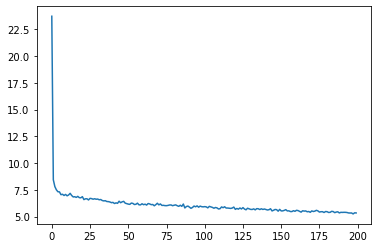

<IPython.core.display.Javascript object>

In [123]:
plt.plot(history.history["RMSE"])

In [124]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.941 (0.000)
MAE: 3.088 (0.000)
MAPE: 0.063 (0.000)
R2: 0.677 (0.000)


******
[TEST]
******
RMSE: 9.391 (0.000)
MAE: 8.073 (0.000)
MAPE: 0.176 (0.000)
R2: 1.868 (0.000)




<IPython.core.display.Javascript object>

In [125]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_ii

In [126]:
df_partner_ii = pd.read_csv("../../../data/processed/partner_ii/cement-shipping.csv")
df_no_cs = df_partner_ii.drop(
    ["strength_1d", "strength_3d", "strength_7d"],
    axis=1,
).copy()
y = df_no_cs.pop("strength_28d")
x = df_no_cs.rename({"sample_date": "date"}, axis=1)

x.columns = x.columns.str.lower()
x = x[COMMON_FEATURES]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [127]:
set_seeds()
model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten()(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
class1 = tf.keras.layers.Dense(128, activation="relu")(class1)
class1 = tf.keras.layers.Dense(64, activation="relu")(class1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [128]:
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)


<IPython.core.display.Javascript object>

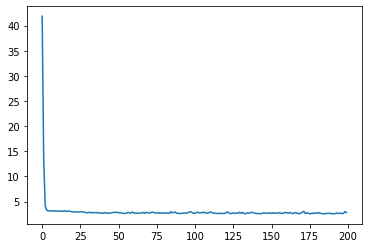

<IPython.core.display.Javascript object>

In [129]:
plt.plot(history.history["RMSE"])

In [130]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.617 (0.000)
MAE: 2.086 (0.000)
MAPE: 0.047 (0.000)
R2: 0.356 (0.000)


******
[TEST]
******
RMSE: 3.744 (0.000)
MAE: 3.173 (0.000)
MAPE: 0.082 (0.000)
R2: 0.807 (0.000)




<IPython.core.display.Javascript object>

# Pre Trainning

# partner_i

In [131]:
batch_size = 32
epochs = 200
verbose = 0

<IPython.core.display.Javascript object>

In [132]:
COMMON_FEATURES_partner_i = ["%limestone", "%gypsum", "%clinker"]

<IPython.core.display.Javascript object>

In [133]:
df_partner_i = pd.read_csv(
    "../../../data/processed/partner_i-Oficial/cement-shipping.csv"
)
df_partner_i = df_partner_i.drop(
    [
        "1 day Compressive strength",
        "3 day Compressive strength",
        "7 day Compressive strength",
    ],
    axis=1,
).copy()

y = df_partner_i.pop("28 day Compressive strength")
df_partner_i.columns = df_partner_i.columns.str.lower()
x = df_partner_i[COMMON_FEATURES_partner_i]


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [134]:
set_seeds()

model = get_model(shape=x_train.shape[-1], include_top=True)
sc = StandardScaler()

history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

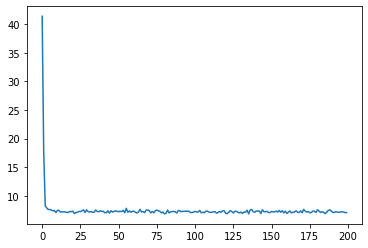

<IPython.core.display.Javascript object>

In [135]:
plt.plot(history.history["RMSE"])

In [136]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))
scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 5.061 (0.000)
MAE: 4.632 (0.000)
MAPE: 0.112 (0.000)
R2: 0.005 (0.000)


******
[TEST]
******
RMSE: 5.084 (0.000)
MAE: 4.809 (0.000)
MAPE: 0.114 (0.000)
R2: 0.046 (0.000)




<IPython.core.display.Javascript object>

In [137]:
model.save_weights("conv1d_weights.h5")

<IPython.core.display.Javascript object>

# Fine Tuning

# partner_iii

In [138]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [139]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [140]:
set_seeds()

model_2 = get_model(include_top=False, shape=(x.shape[-1]))
model_2.load_weights("conv1d_weights.h5", by_name=True)
model_2.trainable = True

flat1 = tf.keras.layers.Flatten(name="Flatten2")(model_2.layers[-1].output)
class1 = tf.keras.layers.Dense(256, activation="relu")(flat1)
outputs = tf.keras.layers.Dense(1, activation="linear")(class1)
model = tf.keras.Model(model_2.inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [141]:
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

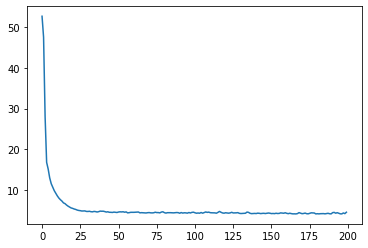

<IPython.core.display.Javascript object>

In [142]:
plt.plot(history.history["RMSE"])

In [143]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.778 (0.000)
MAE: 3.826 (0.000)
MAPE: 0.072 (0.000)
R2: 0.569 (0.000)


******
[TEST]
******
RMSE: 3.459 (0.000)
MAE: 2.663 (0.000)
MAPE: 0.051 (0.000)
R2: 0.181 (0.000)




<IPython.core.display.Javascript object>

# partner_iii

In [144]:
df_partner_iii = pd.read_csv(
    "../../../data/interim/partner_iii/Dati CADD 2020-2022_with_fillna.csv"
)

<IPython.core.display.Javascript object>

In [145]:
y = df_partner_iii.pop("28d compressive strength (MPa)")
x = df_partner_iii

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=SEED, shuffle=False
)

<IPython.core.display.Javascript object>

In [146]:
set_seeds()
model = get_model(include_top=True, shape=(x.shape[-1]))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
)

<IPython.core.display.Javascript object>

In [147]:
sc = StandardScaler()
history = model.fit(
    sc.fit_transform(x_train),
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
)

<IPython.core.display.Javascript object>

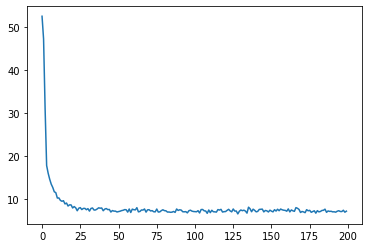

<IPython.core.display.Javascript object>

In [148]:
plt.plot(history.history["RMSE"])

In [149]:
y_train_pred = model.predict(sc.transform(x_train))
y_test_pred = model.predict(sc.transform(x_test))

scores = score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.134 (0.000)
MAE: 3.169 (0.000)
MAPE: 0.061 (0.000)
R2: 0.678 (0.000)


******
[TEST]
******
RMSE: 4.282 (0.000)
MAE: 3.113 (0.000)
MAPE: 0.062 (0.000)
R2: 0.255 (0.000)




<IPython.core.display.Javascript object>